**[TensorBoard: TensorFlow's visualization toolkit](https://www.tensorflow.org/tensorboard)**

For more information check out the [PyTorch documentation about TensorBoard](https://pytorch.org/docs/stable/tensorboard).

## Construct Neural Network

In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [38]:
# device and tensorboard writer config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter("runs/mnist")

# hyperparameters
input_size = 784  # 28 * 28
hidden_size = 100
num_classes = 10
n_epochs = 2
batch_size = 64
learning_rate = 0.01

In [39]:
# load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          transform=transforms.ToTensor(),
                                          download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size,
                                          shuffle=True)

In [40]:
examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


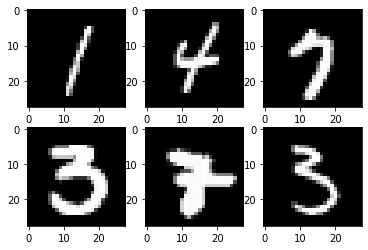

In [41]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')

# write image to tensorboard
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()

In [42]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out 
    # Note that since it's a multi classification
    # We don't need to apply a softmax function here
    # but if it's a binary classification one we need to apply a sigmoid function here

model = NeuralNet(input_size, hidden_size, num_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [43]:
# Write model graph to tensorboard
writer.add_graph(model, samples.reshape(-1, 28*28))
writer.close()

In [44]:
# Training loop
n_total_steps = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader): # 100, 1, 28, 28
        # 100, 1, 28, 28 --> 10, 784
        images = images.reshape(-1, 28 * 28).to(device) # push to device
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        # zero gradients
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print(f"epoch {epoch+1} / {n_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}")
            writer.add_scalar('training loss',running_loss / 100, epoch * n_total_steps + i) # Write metrics to tensorboard
            writer.add_scalar('accuracy',running_correct / 100, epoch * n_total_steps + i)
            running_loss = 0.0 # Reset
            running_correct = 0 # Reset

epoch 1 / 2, step 100 / 938, loss = 0.3166
epoch 1 / 2, step 200 / 938, loss = 0.2526
epoch 1 / 2, step 300 / 938, loss = 0.2410
epoch 1 / 2, step 400 / 938, loss = 0.2266
epoch 1 / 2, step 500 / 938, loss = 0.1501
epoch 1 / 2, step 600 / 938, loss = 0.2173
epoch 1 / 2, step 700 / 938, loss = 0.1298
epoch 1 / 2, step 800 / 938, loss = 0.3998
epoch 1 / 2, step 900 / 938, loss = 0.1330
epoch 2 / 2, step 100 / 938, loss = 0.0211
epoch 2 / 2, step 200 / 938, loss = 0.0631
epoch 2 / 2, step 300 / 938, loss = 0.2197
epoch 2 / 2, step 400 / 938, loss = 0.1911
epoch 2 / 2, step 500 / 938, loss = 0.1537
epoch 2 / 2, step 600 / 938, loss = 0.1808
epoch 2 / 2, step 700 / 938, loss = 0.2013
epoch 2 / 2, step 800 / 938, loss = 0.1674
epoch 2 / 2, step 900 / 938, loss = 0.0934


In [52]:
# testing
labels = []
predictions = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for image, label in test_loader:
        image = image.reshape(-1, 28*28).to(device)
        label = label.to(device)
        outputs = model(image)
        
        # value, index
        _, preds = torch.max(outputs.data, 1)
        n_samples += label.size(0)
        n_correct += (preds == label).sum().item()
        
        class_predictions = [torch.softmax(output, dim=0) for output in outputs]
        
        labels.append(preds)
        predictions.append(class_predictions)
    
    predictions = torch.cat([torch.stack(batch) for batch in predictions])
    labels = torch.cat(labels)
    
    acc = 100.0 * n_correct / n_samples
    print(f"accuracy = {acc}")
    
    classes = range(10)
    for i in classes:
        labels_i = labels == i
        preds_i = predictions[:, i]
        writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
        writer.close()

accuracy = 96.61
